<a href="https://colab.research.google.com/github/rachioko/Neural-Networks-with-Tensorflow/blob/master/Artistry_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook shows a project which will attempt to predict the artist who painted an image of an artwork. We will be using a convolution neural network architechture in tensorflow.

In [0]:
import pandas as pd
import numpy as np
import os
#from tqdm import tqdm 
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
df = pd.read_csv("all_data_info.csv")
traininfo = pd.read_csv("train_info.csv")
traininfo.head()

,filename,artist,title,style,genre,date
0,102257.jpg,5b39c876740bfc1cfaf544721c43cac3,Uriel,Color Field Painting,abstract,1955.0
1,75232.jpg,5b39c876740bfc1cfaf544721c43cac3,Vir Heroicus Sublimis,Color Field Painting,abstract,1950.0
2,29855.jpg,96e5bc98488ed589b9bf17ad9fd09371,Night March of a Hundred Demons (left half),Yamato-e,mythological painting,NaN
3,62252.jpg,5b39c876740bfc1cfaf544721c43cac3,"Who’s Afraid of Red, Yellow and Blue II",Color Field Painting,abstract,NaN
4,63861.jpg,5b39c876740bfc1cfaf544721c43cac3,Black Fire I,Color Field Painting,abstract,1963.0


In [4]:
print (df.describe())
print(df['artist'].value_counts())

             pixelsx        pixelsy    size_bytes
count  103250.000000  103250.000000  1.032500e+05
mean      960.808097     984.089976  3.883235e+05
std       596.270314     625.139336  8.784776e+05
min       200.000000     162.000000  3.516000e+03
25%       581.000000     599.000000  9.438625e+04
50%       800.000000     800.000000  1.676700e+05
75%      1102.000000    1097.000000  3.401280e+05
max     25528.000000    9541.000000  3.244314e+07
Pablo Picasso                                         500
Marc Chagall                                          500
Albrecht Durer                                        500
John Singer Sargent                                   500
Rembrandt                                             500
Ilya Repin                                            500
Pierre-Auguste Renoir                                 500
Giovanni Battista Piranesi                            500
Gustave Dore                                          500
Zdislav Beksinski           

So we have 2319 artists to look at, but for this project we will only choose 4 artistes with 500 painting for labels to use for the Image classification. Therefore, we have a project dataset of 2,000 images.

In [20]:
#get 4 artists with 500 entries for new dataframe
p_artists = ['Ivan Shishkin', 'Pablo Picasso', 'Marc Chagall', 'Rembrandt' ]
art_df = df[df.artist.isin(p_artists)]
art_df_train = art_df[art_df.new_filename.isin(traininfo.filename)]
art_df_test = art_df[~art_df.new_filename.isin(art_df_train.new_filename)]

art_df_train.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
112,Rembrandt,NaN,portrait,4032.0,5008.0,1384905.0,wikiart,Baroque,Lady with a Lap Dog,train_and_test,True,40672.jpg
551,Ivan Shishkin,1896.0,landscape,4316.0,2880.0,2687846.0,wikiart,Realism,The Forest Clearing,train_and_test,True,71922.jpg
588,Rembrandt,1658,self-portrait,3054.0,3957.0,7459899.0,wikiart,Baroque,Self-portrait,train_and_test,True,60634.jpg
1102,Ivan Shishkin,1878.0,landscape,4000.0,2254.0,7186319.0,wikiart,Realism,The Field of Wheat,train_and_test,True,39817.jpg
1891,Rembrandt,1661,self-portrait,2434.0,3040.0,1382385.0,wikiart,Baroque,Self-portrait as the Apostle Paul,train_and_test,True,1680.jpg


In [0]:
training_dir = "/content/drive/My Drive/Colab Notebooks/Data/art_training/"
test_dir = "/content/drive/My Drive/Colab Notebooks/Data/art_test/"

In [7]:
#list of training and test : images and labels
train_img = os.listdir(training_dir)
train_labels = pd.Series.tolist(art_df['artist'][art_df['new_filename'].isin(train_img)])
test_img = os.listdir(test_dir)
test_labels = pd.Series.tolist(art_df['artist'][art_df['new_filename'].isin(test_img)])

#check that we have 2000 images as planned.
train_size, val_size = len(train_img), len(test_img)
total = train_size + val_size

print("total images: ",total)

total images:  2000


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [0]:
#CNN Tensorflow  
#Training parameters
learning_rate = 0.01
epochs = 20
batch_size =  128 
labels = 4
img_size = 512
dropout = 0.2 


Image Processing, we will get all our images to a 512x512.

In [23]:
#Data Preprocessing
train_generator = ImageDataGenerator(rescale = 1./255)
val_generator = ImageDataGenerator(rescale = 1./255)

train_gen = train_generator.flow_from_dataframe( 
    art_df_train,
    directory = training_dir,
    x_col = 'new_filename', 
    y_col = 'artist',  
    target_size = (img_size,img_size)
)

Found 1487 validated image filenames belonging to 4 classes.


In [24]:
val_gen = val_generator.flow_from_dataframe( 
    art_df_test,
    directory = test_dir,
    x_col = 'new_filename', 
    y_col = 'artist',  
    target_size = (img_size,img_size)
)

Found 513 validated image filenames belonging to 4 classes.


In [0]:
#lets visualizr some images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
sample_training_images, _ = next(train_gen)

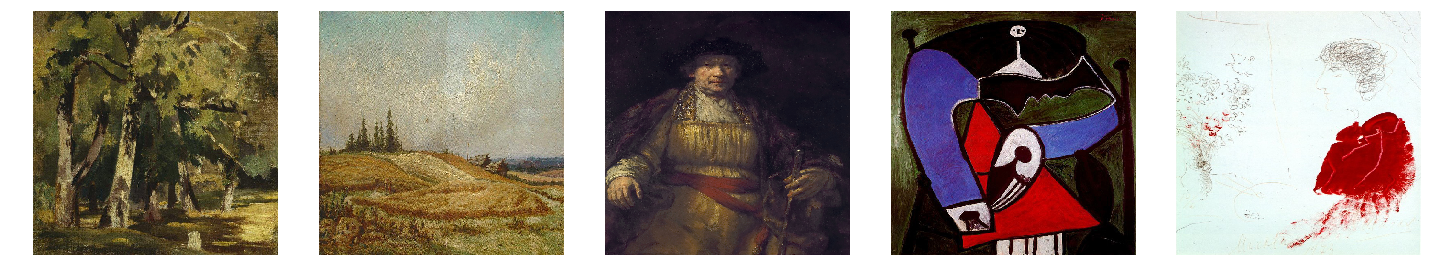

In [29]:
plotImages(sample_training_images[:5])

TIME TO CREATE THE MODEL 

In [0]:
model = Sequential([
    Conv2D(16,3, padding ='same', activation = 'relu', 
           input_shape = (img_size,img_size,3)),
    MaxPooling2D(),
    Conv2D(32,3,padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(64,3,padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(128,3,padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Dropout(dropout),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dense(4, activation = 'sigmoid')
])

In [31]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 128)      

In [33]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_size // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_size // batch_size
)

Epoch 1/20
11/11 [==============================] - 21s 2s/step - loss: 1.3357 - acc: 0.6946 - val_loss: 0.5686 - val_acc: 0.7500
Epoch 2/20
11/11 [==============================] - 15s 1s/step - loss: 0.5549 - acc: 0.7500 - val_loss: 0.5186 - val_acc: 0.7520
Epoch 3/20
11/11 [==============================] - 18s 2s/step - loss: 0.4904 - acc: 0.7656 - val_loss: 0.4909 - val_acc: 0.7188
Epoch 4/20
11/11 [==============================] - 17s 2s/step - loss: 0.4568 - acc: 0.7834 - val_loss: 0.4116 - val_acc: 0.7988
Epoch 5/20
11/11 [==============================] - 16s 1s/step - loss: 0.3694 - acc: 0.8254 - val_loss: 0.3410 - val_acc: 0.8555
Epoch 6/20
11/11 [==============================] - 16s 1s/step - loss: 0.3404 - acc: 0.8594 - val_loss: 0.3841 - val_acc: 0.8164
Epoch 7/20
11/11 [==============================] - 15s 1s/step - loss: 0.3462 - acc: 0.8395 - val_loss: 0.3638 - val_acc: 0.8516
Epoch 8/20
11/11 [==============================] - 15s 1s/step - loss: 0.3259 - acc: 0.86

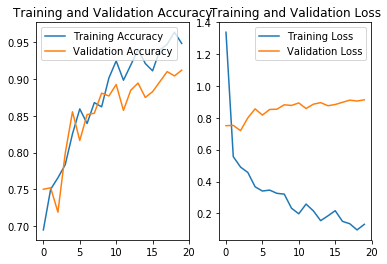

In [35]:
#Visualize results
acc= history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc = "upper left")
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_acc, label='Validation Loss')
plt.legend(loc = "upper right")
plt.title('Training and Validation Loss')

plt.show()

Training accuracy and validation accuracy are pretty close so we can accept this.

Validation accuracy is at 91%. Very happy with that '') 